In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install opencv-contrib-python
!pip install cloudinary
!pip install Pillow


Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


In [ ]:
import cv2
import glob
import time
import pytesseract
import argparse
import re
import requests
import json
import cloudinary
import cloudinary.uploader
import cloudinary.api

import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from PIL import Image
#from pynq import allocate, Overlay

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [ ]:
class PlateDetection:
    #initializing the class with properties and necessary functions
    def __init__(
            self, pth_weights: str, 
            pth_cfg: str, pth_classes: str):
        
        self.net = cv2.dnn.readNet(pth_weights, pth_cfg)
        self.classes = []
        with open(pth_classes, 'r') as f:
            self.classes = f.read().splitlines()
        self.font = cv2.FONT_HERSHEY_PLAIN
        self.color = (0, 0, 255)
        self.coordinates = None
        self.img = None
        self.fig_image = None
        self.roi_image = None
        
    # detection of object if the bounding box exceeds a certain confidence score    
    def detect(self, img_path: str):
        boxes = []
        confidences = []
        class_ids = []
        orig = cv2.imread(img_path)
        self.img = orig
        img = orig.copy()
        height, width, _ = img.shape
        blob = cv2.dnn.blobFromImage(
            img, 
            1 / 255, 
            (416, 416), 
            (0, 0, 0), 
            swapRB=True, 
            crop=False
        )
        self.net.setInput(blob)
        output_layer_names = self.net.getUnconnectedOutLayersNames()
        layer_outputs = self.net.forward(output_layer_names)

        for output in layer_outputs:
            for detection in output:
                scores = detection[5:]
                class_id = np.argmax(scores) 
                confidence = scores[class_id]
                if confidence > 0.2:
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)
                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)

                    boxes.append([x, y, w, h])
                    confidences.append((float(confidence)))
                    class_ids.append(class_id)

        indexes = cv2.dnn.NMSBoxes(
            boxes, 
            confidences, 
            0.2, 
            0.4
        )

        if len(indexes) > 0:
            for i in indexes.flatten():
                x, y, w, h = boxes[i]
                label = str(self.classes[class_ids[i]])
                confidence = str(round(confidences[i],2))
                cv2.rectangle(
                    img,(x,y),
                    (x + w, y + h), 
                    self.color, 
                    8
                )
                cv2.putText(
                    img,
                    label + ' ' + confidence, 
                    (x, y + 20),
                    self.font, 
                    5, 
                    (255, 255, 255), 
                    3
                )
        self.fig_image = img
        self.coordinates = (x, y, w, h)
        return
    
    # only have the image contain the regions of interest
    def crop_plate(self):
        x, y, w, h = self.coordinates
        roi = self.img[y:y + h, x:x + w]
        self.roi_image = roi
        return

In [ ]:
# Adding image

##### Image Version Server URLs #####
version_prod_url = "https://lpd.mosaicsensed.com/version"

#### Cloudinary API Configuration #####
cloudinary.config( 
    cloud_name= "dsqw5kd59",
    api_key= "776857344324132",
    api_secret= "cNO50ceR5k3YJrR7c4WQZq5ZQKE",
    secure= True
)

##### Cloudinary API Image Upload #####
def upload_image(img_path):
    resp = cloudinary.uploader.upload(
        img_path,
        invalidate = True,
        folder = "stream/",
        public_id = "latest"
    )
    
    ##### Cloudinary Response #####    
    print(resp)
    
    ##### Image Version Sync (Cacheing solution) #####
    r = requests.post(
        version_prod_url,
        data = {
            "version":resp["version"]
        }
    )
                                      

In [ ]:
# Adding car entry to database
""" GraphQL queries/mutations endpoint testing for license plate database (lpd) schema"""

##### GraphQL Server URLs #####
prod_url = "https://lpd.mosaicsensed.com/graphql"

##### Add Car Mutation #####
mutation_add_car = """mutation AddCar($inputs: Car_Add_Inputs!) {
  add_car(inputs: $inputs) {
    lp
    car_model
    car_color
    createdAt
    updatedAt
    location
    name
    state
    inCapture
  }
}
"""

##### Current Date as String #####
date = str(int(datetime.timestamp(datetime.now())))

##### HTTP POST Request to GraphQL Endpoint #####
def upload_data(plate):
    r = requests.post(
        prod_url,
        json={
            'query' : mutation_add_car,
            'variables': {
                "inputs":{
                    "lp" : plate,
                    "car_model": "unknown",
                    "car_color": "unknown",
                    "location": "Los Angeles",
                    "name": "unknown",
                    "state": "CA",
                    # Determines if car is shown on frontend or not
                    "inCapture": True
                }
            }
        }
    

    )
    ##### Request Status #####
    print(r.status_code)
    if(r.status_code != 200):
        print("error")
    ##### Query Outputs #####
    #if(r.text):
        #parsed = json.load(r.text)
        #print(json.dumps(parsed, indent=4, sort_keys=True))

In [ ]:
#function to send data 
def run_kernel():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)    
    resizer.write(0x00,0x81) # start
    dma.sendchannel.wait()
    dma.recvchannel.wait()

#the resize operation which can only run on the pynq
#need the bit files in the proper path
def resize(image_path):
    resize_design = Overlay("resizer.bit")
    dma = resize_design.axi_dma_0
    resizer = resize_design.resize_accel_0
    original_image = Image.open(image_path)
    
    resize_factor = 2 #can change based on need
    new_width = int(old_width/resize_factor)
    new_height = int(old_height/resize_factor)
    in_buffer = allocate(shape=(old_height, old_width, 3), 
                           dtype=np.uint8, cacheable=1)
    out_buffer = allocate(shape=(new_height, new_width, 3), 
                            dtype=np.uint8, cacheable=1)
    resizer.register_map.src_rows = old_height
    resizer.register_map.src_cols = old_width
    resizer.register_map.dst_rows = new_height
    resizer.register_map.dst_cols = new_width
    
    run_kernel()
    resized_image = Image.fromarray(out_buffer)
    return resized_image

    del in_buffer
    del out_buffer

In [ ]:
#establishes the paths of the weights, config, and class files
pd = PlateDetection(
    pth_weights='yolov3_training_final.weights', 
    pth_cfg='yolov3_testing.cfg',
    # pth_cfg='yolov3_tiny_testing.cfg'
    pth_classes='classes.txt'
)

#goes through every png image in the test file
#it runs the detect and outputs various steps of detection
#saves the cropped and image with the bounding box
for img in glob.glob('test-images/*.png'):
    pd.detect(img)
    plt.imshow(cv2.cvtColor(pd.fig_image, cv2.COLOR_BGR2RGB))
    plt.savefig('detected_{}.png'.format(int(time.time())))
    pd.crop_plate()
    plt.figure(figsize=(10, 4))
    plt.imshow(cv2.cvtColor(pd.roi_image, cv2.COLOR_BGR2RGB))
    plt.savefig('plates/plate_{}.png'.format(int(time.time())))

NameError: ignored

{'asset_id': '131d64457c2019c6772155ffcf0928e6', 'public_id': 'stream/latest', 'version': 1651252588, 'version_id': '79307fa43583c8063a6bb6bea85025a4', 'signature': '6809feda7ad2d39f89bd0800dbaa893aa677c1e3', 'width': 720, 'height': 288, 'format': 'png', 'resource_type': 'image', 'created_at': '2022-01-15T00:00:56Z', 'tags': [], 'bytes': 170444, 'type': 'upload', 'etag': 'a17a45f1ac5bd682a504e69ac842a2db', 'placeholder': False, 'url': 'http://res.cloudinary.com/dsqw5kd59/image/upload/v1651252588/stream/latest.png', 'secure_url': 'https://res.cloudinary.com/dsqw5kd59/image/upload/v1651252588/stream/latest.png', 'folder': 'stream', 'overwritten': True, 'original_filename': 'plate_1651252574', 'api_key': '776857344324132'}
| 7yo0160)

200


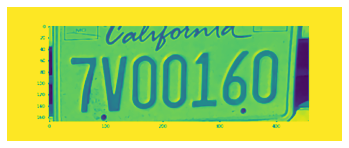

In [ ]:
plates = []

#goes through every png files saved in the cropped process
#it uploads the image to the server and apply image processing
#the result is read through the OCR
#the text is processed to extract valid readings and sent to server
for img in glob.glob('plates/*.png'):
    upload_image(img)
    plate = cv2.imread(img)
    filtered = cv2.bilateralFilter(plate, 11, 17, 17) 
    denoised = cv2.medianBlur(filtered,3)
    gray = cv2.cvtColor(denoised, cv2.COLOR_RGB2GRAY)
    #thres = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 45, 15)
    plt.imshow(gray)
    plt.axis('off')
    text = pytesseract.image_to_string(gray, config="--oem 3 --psm 4") # Need to configure based on the state
    print(text)
    
    for line in text.splitlines():
        output = re.findall(r'\w+', line)
        output_txt = ''.join(output)
        line_len = len(output_txt)
        if(len(output_txt) > 5 and len(output_txt) < 9):
            upload_data(output_txt)
            plates.append(output_txt + '\n')
            
f = open('plates.txt', 'w')
f.writelines(plates)

In [ ]:
# Adding car entry to database
""" GraphQL queries/mutations endpoint testing for license plate database (lpd) schema"""

##### GraphQL Server URLs #####
prod_url = "https://lpd.mosaicsensed.com/graphql"

##### Add Car Mutation #####
remove_all = """mutation RemoveAll {
  remove_all
}
"""

##### Current Date as String #####
date = str(int(datetime.timestamp(datetime.now())))

##### HTTP POST Request to GraphQL Endpoint #####
def remove():
    r = requests.post(
        prod_url,
        json={
            'query' : remove_all,
            'variables': {
                "inputs":{
                    "lp" : "",
                    "car_model": "unknown",
                    "car_color": "unknown",
                    "location": "Los Angeles",
                    "name": "unknown",
                    "state": "CA",
                    # Determines if car is shown on frontend or not
                    "inCapture": True
                }
            }         
        }
    

    )
    ##### Request Status #####
    print(r.status_code)
    if(r.status_code != 200):
        print("error")
    ##### Query Outputs #####
    if(r.text):
        parsed = json.load(r.text)
        print(json.dumps(parsed, indent=4, sort_keys=True))

In [ ]:
remove()

200


AttributeError: ignored